In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.inspection import partial_dependence, plot_partial_dependence

In [2]:
# load data
stu_19 = pd.read_csv('../data/summary_student.csv')

In [3]:
stu_19.head(2)

,dbn,school_name,student_response_rate,1a,1b,1c,1d,1e,1f,1g,...,8b,8c,8d,8e,8f,8g,8h,9a,9b,combined_mean_score
0,01M034,P.S. 034 FRANKLIN D. ROOSEVELT,95.0,17.31,20.33,13.86,14.69,30.21,26.27,19.69,...,2.62,2.50,2.68,2.46,2.76,1.73,1.80,3.11,3.16,587.928579
1,01M140,P.S. 140 NATHAN STRAUS,87.0,16.22,13.52,11.91,12.06,25.48,18.44,18.73,...,2.34,2.13,2.41,2.67,2.67,1.47,1.81,3.16,3.18,589.583906


In [4]:
# Instantiate X
X = stu_19.iloc[:, 3:-1]
y = stu_19['combined_mean_score']

In [5]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=77)

In [6]:
# scale data
ss = StandardScaler()
X_train_ss = ss.fit_transform(X_train, y_train)
X_test_ss = ss.transform(X_test
                        )
# model
gboost = GradientBoostingRegressor()
gboost.fit(X_train_ss, y_train)

GradientBoostingRegressor()

In [7]:
# cross validate
cross_val_score(gboost, X_train_ss, y_train)

array([0.58806705, 0.67701668, 0.7437359 , 0.6373223 , 0.6036581 ])

In [8]:
# score
gboost.score(X_test_ss, y_test)

0.6352673033330916

In [9]:
# predict
preds = gboost.predict(X_test_ss)

In [10]:
def adj_r2(y_true, y_preds, features):
    '''Calculates the adjusted R2 score from y_true, y_preds, and the  number of features.
    This function uses the r2_score function from sklearn.
    '''
    n = len(y_true)
    true_mean = np.mean(y_true)
    r2 = r2_score(y_true, y_preds)
    adj_r2 = 1 - (1 - r2) * (n - 1) / (n - features - 1)
    return adj_r2

In [11]:
adj_r2(y_test, preds, 58)

0.2940657483866288

In [12]:
mean_squared_error(y_test, preds)

50.69548224930533

In [13]:
gboost_df = pd.DataFrame({'question': X.columns, 'importance': gboost.feature_importances_})

In [14]:
# sort by importance
gboost_df = gboost_df.sort_values(by='importance', ascending=False)

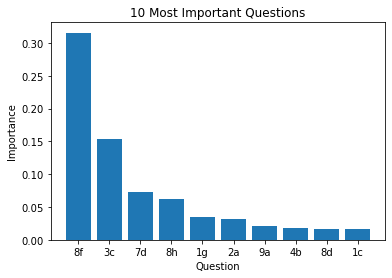

In [15]:
plt.bar(x = gboost_df['question'][:10], height=gboost_df['importance'][:10])
plt.title('10 Most Important Questions')
plt.xlabel('Question')
plt.ylabel('Importance');

In [16]:
X_train_df = pd.DataFrame(X_train_ss, columns=X.columns)

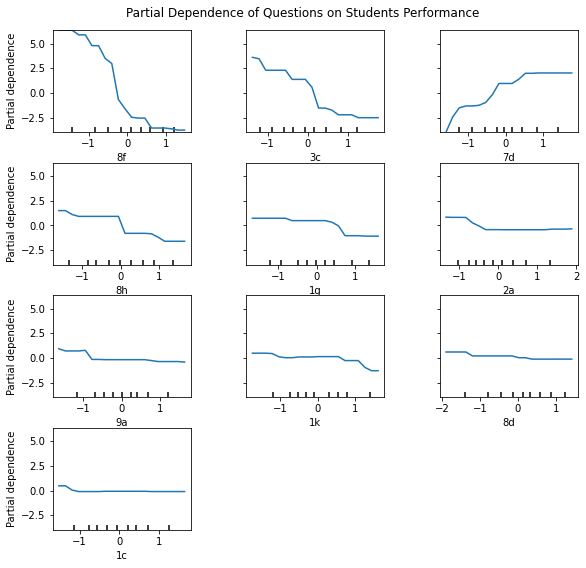

In [17]:
questions = ['8f', '3c', '7d', '8h', '1g', '2a', '9a', '1k', '8d', '1c']
plot_partial_dependence(gboost, X_train_df, questions, n_jobs=-1, grid_resolution=20)
fig = plt.gcf()
fig.set_size_inches(8, 8)
fig.suptitle('Partial Dependence of Questions on Students Performance')
fig.subplots_adjust(wspace=0.4, hspace=0.3)
fig.tight_layout();

Question 3c: My teachers give me specific suggestions about how I can improve my work in class.  
This question, interestingly enough, is negatively correlated.

Question 7d: I feel safe in my classes at this school.   
This question has a linear relationship up to a point after which the it plateus.  

Question 8f: At this school, stduents get into physical fights.  
This question has a negative linear correlation.  

Question 8h: At this school, there is gang activity.  
This question also has a negative relationship.

In [18]:
# partial dependene plots for questions on safey at schools
X_safe = X[[column for column in X.columns if (column.startswith('7')) | (column.startswith('8'))]]

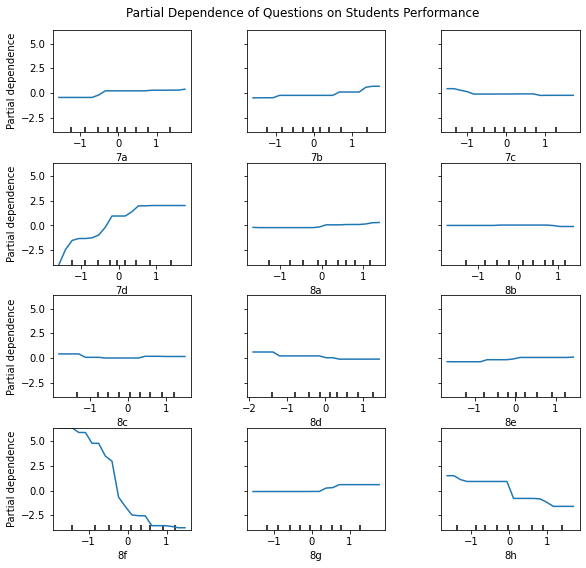

In [19]:
plot_partial_dependence(gboost, X_train_df, X_safe, n_jobs=-1, grid_resolution=20)
fig = plt.gcf()
fig.set_size_inches(8, 8)
fig.suptitle('Partial Dependence of Questions on Students Performance')
fig.subplots_adjust(wspace=0.4, hspace=0.3)
fig.tight_layout();

Question 7d: I feel safe in my classes at this school.   
This question has a linear relationship up to a point after which the it plateus.  

Question 8f: At this school, stduents get into physical fights.  
This question has a negative linear correlation.  

Question 8h: At this school, there is gang activity.  
This question also has a negative relationship.

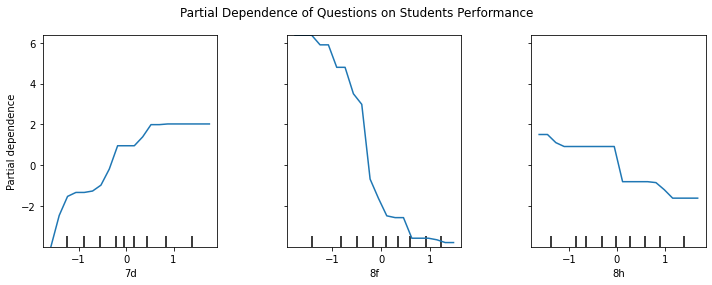

In [27]:
# a plot for presentation
X_present = ['7d', '8f', '8h']
plot_partial_dependence(gboost, X_train_df, X_present, n_jobs=-1, grid_resolution=20)
fig = plt.gcf()
fig.set_size_inches(10, 4)
fig.suptitle('Partial Dependence of Questions on Students Performance')
fig.subplots_adjust(wspace=0.4, hspace=0.3)
fig.tight_layout()
fig.savefig('../assets/partical_dependence_gboost.png', bbox_inches='tight');